In [1]:
import pandas as pd
import numpy as np
import glob
import re
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_theme(style="darkgrid")
plt.rcParams["figure.figsize"] = (20, 15)

train = pd.read_csv('../data/train.csv', index_col='date')
test = pd.read_csv('../data/test.csv', index_col='date')

In [2]:
y_train = train.reel
X_train = train.drop(['reel'], axis=1)
y_test = test.reel
X_test = test.drop(['reel'], axis=1)
X_train.head()

,prevision,cantine_nom,annee_scolaire,effectif,quartier_detail,prix_quartier_detail_m2_appart,prix_moyen_m2_appartement,prix_moyen_m2_maison,longitude,latitude,...,depuis_juives,ramadan_dans,depuis_ramadan,year,day_of_week_sin,day_of_year_sin,day_of_year_cos,week_sin,freq_reel_%,freq_reel_%_std
date,,,,,,,,,,,,,,,,,,,,,
2011-01-03,0.595434,-1.012799,1.087871,-0.269910,-1.091116,-0.653145,-0.408288,-1.120297,0.774209,2.055271,...,-1.301284,0.74085,-1.461039,-1.563869,-0.019917,-0.074069,1.239323,0.015887,-0.399624,-0.714641
2011-01-03,-0.823041,0.207852,-1.222780,-0.680289,0.488899,1.918779,2.339611,0.535862,0.036838,-0.863408,...,-1.301284,0.74085,-1.461039,-1.563869,-0.019917,-0.074069,1.239323,0.015887,-0.082909,1.511968
2011-01-03,1.330463,-0.141474,-0.372606,-0.924563,0.678924,-0.497418,-0.675882,0.238929,-0.720356,-1.375554,...,-1.301284,0.74085,-1.461039,-1.563869,-0.019917,-0.074069,1.239323,0.015887,1.619386,-0.287836
2011-01-03,0.427796,-0.943218,-1.222780,1.127335,0.592007,-0.035104,-0.212652,0.238929,0.139911,-0.048381,...,-1.301284,0.74085,-1.461039,-1.563869,-0.019917,-0.074069,1.239323,0.015887,-1.031682,-0.927143
2011-01-03,1.382043,3.352224,1.706113,-1.002730,-0.686414,1.750886,0.790264,1.196421,0.655278,-0.086929,...,-1.301284,0.74085,-1.461039,-1.563869,-0.019917,-0.074069,1.239323,0.015887,1.718052,-0.139540


## Permutation importance

- Obtenir un modèle entraîné.
- Mélangez les valeurs dans une seule colonne, faites des prédictions en utilisant l'ensemble de données résultant. Utilisez ces prédictions et les vraies valeurs cibles pour calculer dans quelle mesure la fonction de perte a souffert du brassage. Cette détérioration des performances mesure l'importance de la variable que vous venez de mélanger.
- Remettez les données dans l'ordre initial (en annulant le mélange de l'étape 2). Répétez maintenant l'étape 2 avec la colonne suivante de l'ensemble de données, jusqu'à ce que vous ayez calculé l'importance de chaque colonne.


In [3]:
import glob, re, pickle, os

models = {}
for model in glob.glob("models/*.sav"):
    loaded_model = pickle.load(open(model, 'rb'))
    name = os.path.basename(model)
    name = os.path.splitext(name)[0]
    models[name] = loaded_model

In [5]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(models['best_lgbr'], random_state=1).fit(X_train, y_train)
eli5.show_weights(perm, feature_names = X_train.columns.tolist())

Les valeurs situées vers le haut sont les caractéristiques les plus importantes, et celles situées vers le bas sont les moins importantes.

Le premier chiffre de chaque ligne indique de combien les performances du modèle ont diminué avec un brassage aléatoire (dans ce cas, en utilisant la "précision" comme mesure de performance).

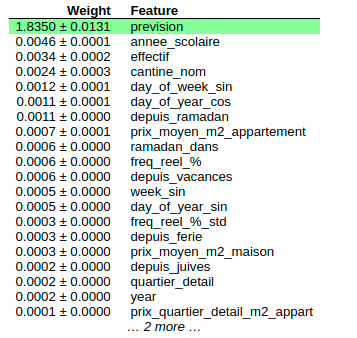

Ici, PermutationImportance confirme la robustesse des enseignements de notre lightGBM. 

Comme la plupart des choses dans la science des données, il y a une part d'aléatoire dans le changement de performance exact résultant du brassage d'une colonne. Nous mesurons la part d'aléatoire dans notre calcul de l'importance de la permutation en répétant le processus avec plusieurs mélanges. Le chiffre après le ± mesure la variation des performances d'un mélange à l'autre.
 

## Partial dependence plots

Alors que l'importance des caractéristiques montre quelles variables affectent le plus les prédictions, les graphiques de dépendance partielle montrent comment une caractéristique affecte les prédictions.

Ceci est utile pour répondre à des questions telles que :

- En contrôlant toutes les autres caractéristiques, quel est l'impact de la longitude et de la latitude sur la cible ? En d'autres termes, quelle serait la valeur de y toutes choses égales par ailleurs dans différentes régions ?

- Les différences de santé prévues entre deux groupes sont-elles dues à des différences dans leur régime alimentaire ou à un autre facteur ?

Un peu comme les modèles de régression linéaire ou logistique, les diagrammes de dépendance partielle peuvent être interprétés de la même manière que les coefficients de ces modèles. Toutefois, les diagrammes de dépendance partielle de modèles sophistiqués peuvent rendre compte de schémas plus complexes que les coefficients de modèles linéaires simples. 


<AxesSubplot:>

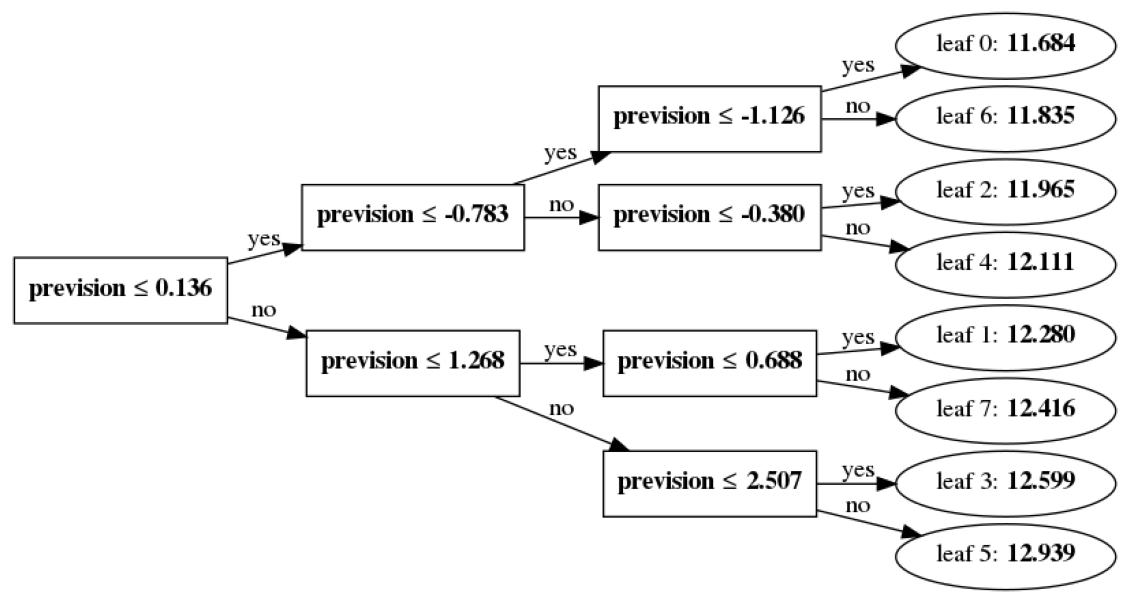

In [10]:
import lightgbm

lightgbm.plot_tree(models['best_lgbr'])

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


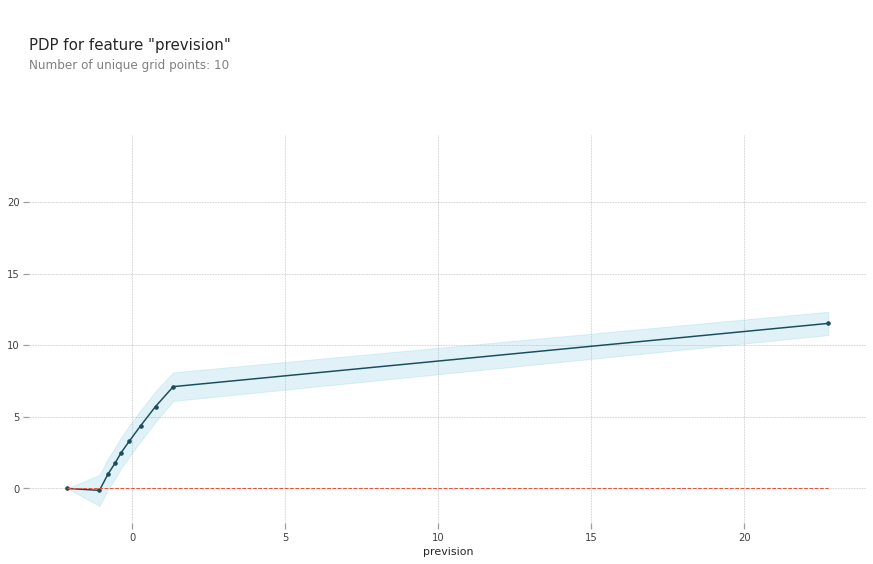

In [14]:
from pdpbox import pdp, get_dataset, info_plots

# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(
    model=models['best_lgbr'], dataset=X_train, model_features=X_train.columns.to_list(), feature='prevision')

# plot it
pdp.pdp_plot(pdp_goals, 'prevision')
plt.show()

Quelques éléments méritent d'être soulignés lors de l'interprétation de ce graphique.

L'axe des y est interprété comme le changement de la prédiction par rapport à ce qu'elle serait à la valeur de base ou la plus à gauche.
Une zone ombrée en bleu indique le niveau de confiance.

Sur ce graphique particulier, nous constatons que l'augmentation des prévisions des agents accroit considérablement les prédictions de fréquentation. Rien de neuf. Explorons d'autres variables.



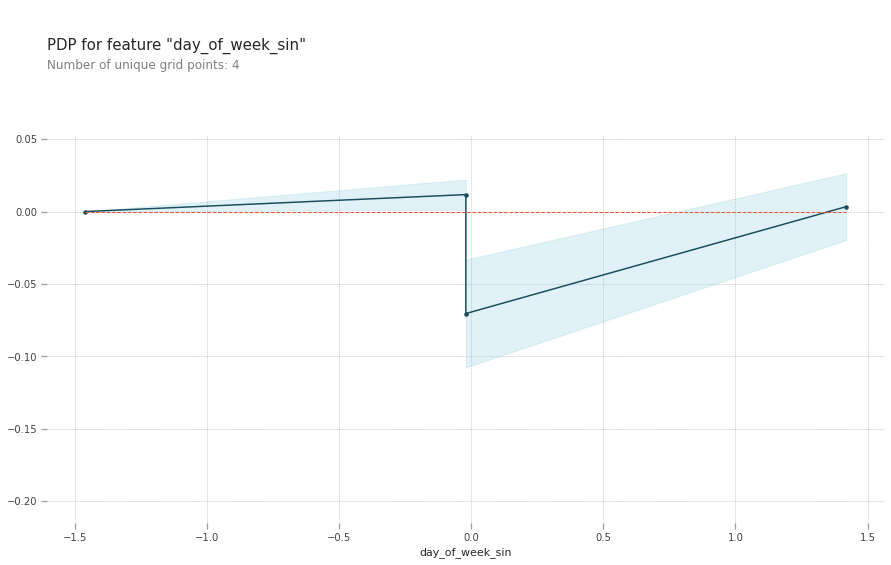

In [16]:
pdp_goals = pdp.pdp_isolate(
    model=models['best_lgbr'], dataset=X_train, model_features=X_train.columns.to_list(), feature='day_of_week_sin')

# plot it
pdp.pdp_plot(pdp_goals, 'day_of_week_sin')
plt.show()

Ici, la valeur la plus basse est le lundi et on constate que le mercredi, il y a une vraie baisse quant à la prédiction de fréquentation par notre light GBM.

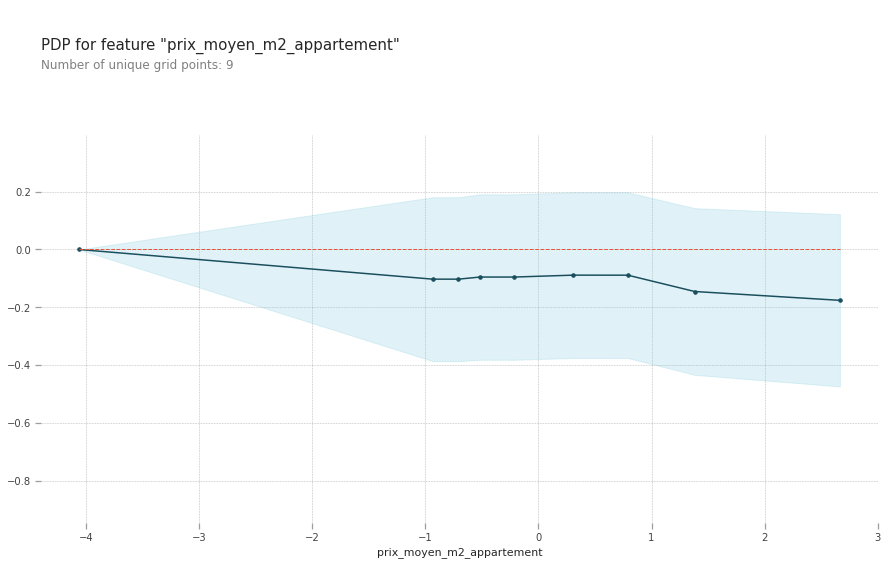

In [18]:
pdp_goals = pdp.pdp_isolate(
    model=models['best_lgbr'], dataset=X_train, model_features=X_train.columns.to_list(), feature='prix_moyen_m2_appartement')

# plot it
pdp.pdp_plot(pdp_goals, 'prix_moyen_m2_appartement')
plt.show()

Ici, on constate que notre modèle prédit une baisse de la fréquentation quand le prix au m2 des appartements croit.

Ainsi, on pourrait extrapoler en affirmant que dans les quartiers plus aisés, notre modèle prédit, TOUTES CHOSES EGALES PAR AILLEURS, une fréquentation plus basse.

Voyons l'influence du ramadan sur la fréquentation des cantines.

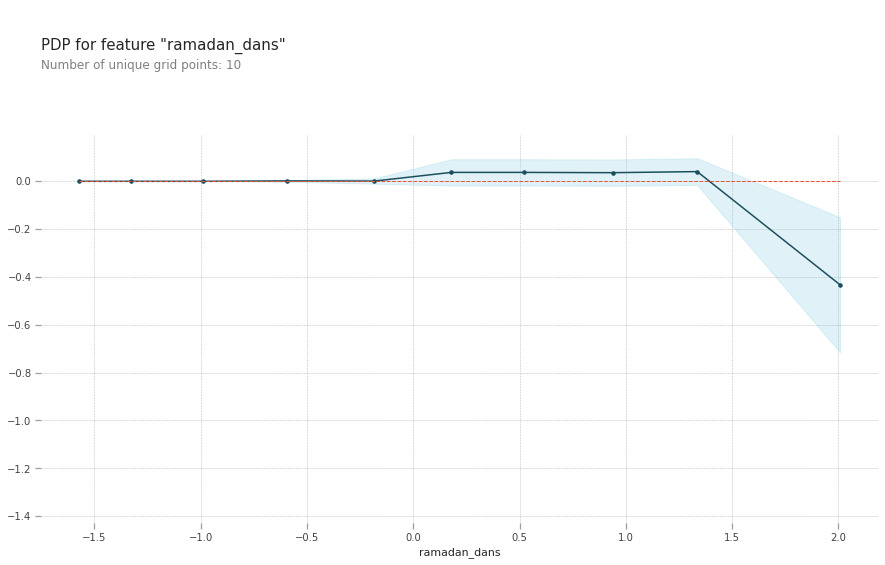

In [20]:
pdp_goals = pdp.pdp_isolate(
    model=models['best_lgbr'], dataset=X_train, model_features=X_train.columns.to_list(), feature='ramadan_dans')

# plot it
pdp.pdp_plot(pdp_goals, 'ramadan_dans')
plt.show()

Ici, on constate bien qu'a l'approche du ramadan, la fréquentation des cantine baisse.

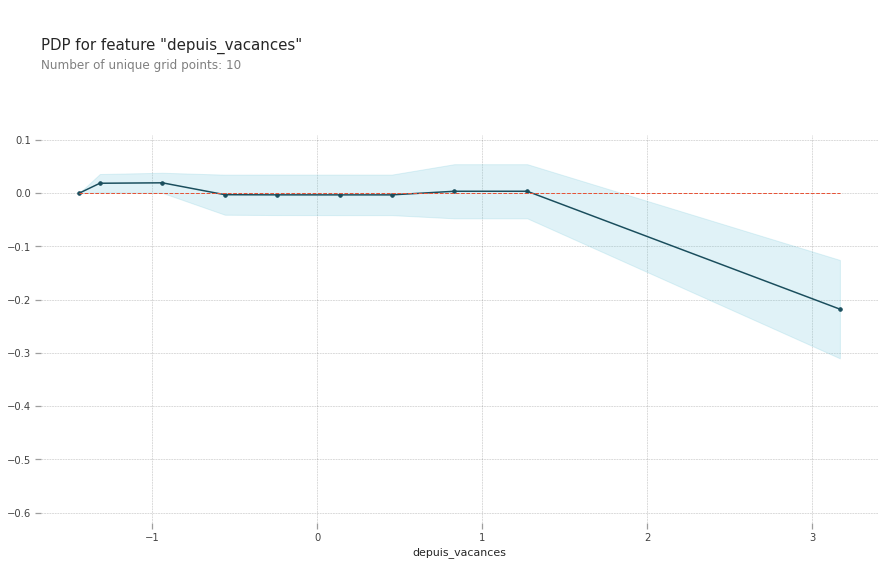

In [24]:
pdp_goals = pdp.pdp_isolate(
    model=models['best_lgbr'], dataset=X_train, model_features=X_train.columns.to_list(), feature='depuis_vacances')

# plot it
pdp.pdp_plot(pdp_goals, 'depuis_vacances')
plt.show()

De même, à l'approche des vacances, le modèle prédit une baisse de la fréquentation des cantines, avec quasi certitude car l'intervalle de confiance suit cette tendance.

Les interactions entre les caractéristiques peuvent être révélées par les graphiques de dépendance partielle en 2D.

In [30]:
# features_to_plot = ['day_of_week_sin', 'day_of_year_cos']
# inter1 = pdp.pdp_interact(model=models['best_lgbr'], dataset=X_train,
#                           model_features=X_train.columns.to_list(), features=features_to_plot)

# pdp.pdp_interact_plot(pdp_interact_out=inter1,
#                       feature_names=X_train.columns.to_list(), plot_type='contour')
# plt.show()

# SHAP Values

Les valeurs SHAP (acronyme de SHapley Additive exPlanations) décomposent une prédiction pour montrer l'impact de chaque variable. Où pourriez-vous utiliser ces valeurs ?

- Si un modèle indique qu'une banque ne devrait pas prêter de l'argent à quelqu'un, la banque est légalement tenue d'expliquer le fondement de chaque refus de prêt.
- Un prestataire de soins de santé veut identifier les facteurs qui déterminent le risque de maladie de chaque patient afin de pouvoir s'attaquer directement à ces facteurs de risque par des interventions sanitaires ciblées.

Les valeurs SHAP interprètent l'impact d'une certaine valeur pour une caractéristique donnée par rapport à la prédiction que nous ferions si cette caractéristique prenait une certaine valeur de base.

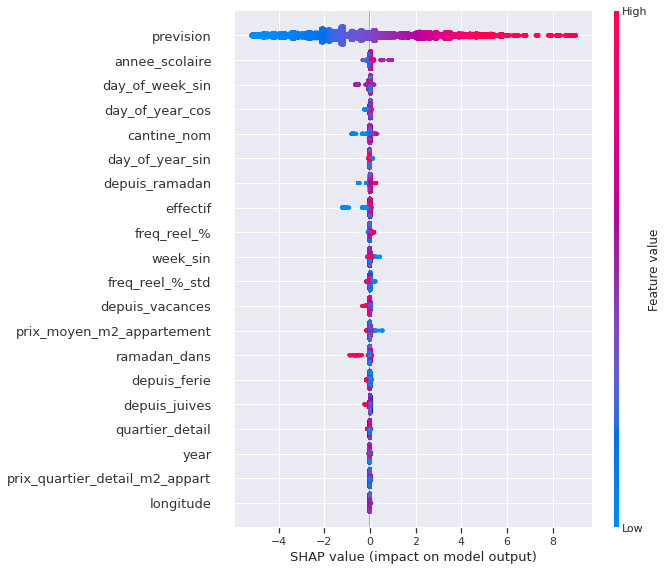

In [48]:
import shap 

# object that can calculate shap values
shap_values = shap.TreeExplainer(models['best_lgbr']).shap_values(X_train)

# summary plot of shape values
shap.summary_plot(shap_values, X_train)

Ce graphique est constitué de tous les points des données du train set. Il montre les informations suivantes :

- Les variables sont classées par ordre décroissant.
- Impact : L'emplacement horizontal montre si l'effet de cette valeur est associé à une prédiction plus élevée ou plus faible.
- Valeur originale : La couleur indique si cette variable est élevée (en rouge) ou faible (en bleu) pour cette observation.
- Corrélation : Un niveau élevé de la valeur de l'année scolaire a un impact élevé et positif sur la fréquentation. Le terme "élevé" vient de la couleur rouge et l'impact "positif" est indiqué sur l'axe des abscisses. De même, un effectif bas implique un bas niveau de fréquentation. Prix moyen est corrélé négativement avec la cible. Le ramadan se rapprochant, la fréquentation baisse.

Attention, les valeurs SHAP n'identifient pas la causalité, qui est mieux identifiée par la conception expérimentale ou des approches similaires.